## 1. k-medoids算法原理

上一篇文章我们详细讲解了 k-means 算法，这篇文章简单介绍一下 k-medoids 算法，从名字上就可以看出来，这两个算法应该有些相似的地方。其实，k-medoids 可以算是 k-means 的一个变种。

k-medoids 和 k-means 不一样的地方在于中心点的选取，在 k-means 中，我们将中心点取为当前 cluster 中所有数据点的平均值。然而在 k-medoids 中，我们将中心点的选取限制在当前 cluster 所包含的数据点的集合中。换句话说，在 k-medoids 算法中，我们将从当前 cluster 中选取这样一个点——它到其他所有(当前 cluster 中的)点的距离之和最小——作为中心点。k-means 和 k-medoids 之间的差异就类似于一个数据样本的均值 (mean) 和中位数 (median) 之间的差异：前者的取值范围可以是连续空间中的任意值，而后者只能在给样本给定的那些点里面选。那么，这样做的好处是什么呢？

一个最直接的理由就是 k-means 对数据的要求太高了，它使用欧氏距离描述数据点之间的差异(dissimilarity)，从而可以直接通过求均值来计算中心点。这要求数据点处在一个欧氏空间之中。

然而并不是所有的数据都能满足这样的要求，对于数值类型的特征，比如身高，可以很自然地用这样的方式来处理，但是类别 (categorical)类型的特征就不行了。举一个简单的例子，如果我现在要对犬进行聚类，并且希望直接在所有犬组成的空间中进行，k-means 就无能为力了，因为欧氏距离 $ \|x_i-x_j\|^2 $在这里不能用了：一只 Samoyed 减去一只 Rough Collie 然后在平方一下？天知道那是什么！再加上一只 German Shepherd Dog 然后求一下平均值？根本没法算，k-means 在这里寸步难行！

在 k-medoids 中，我们把原来的目标函数 J 中的欧氏距离改为一个任意的 dissimilarity measure 函数 $\mathcal{V}$：

$$ \displaystyle\tilde{J} = \sum_{n=1}^N\sum_{k=1}^K r_{nk}\mathcal{V}(x_n,\mu_k) $$

最常见的方式是构造一个dissimilarity matrix $ \mathbf{D} 来代表 \mathcal{V}$，其中的元素 $\mathbf{D}_{ij}$ 表示第 i 只狗和第 j 只狗之间的差异程度，例如，两只 Samoyed 之间的差异可以设为 0 ，一只 German Shepherd Dog 和一只 Rough Collie 之间的差异是 0.7，和一只 Miniature Schnauzer 之间的差异是 1 等等。

除此之外，由于中心点是在已有的数据点里面选取的，因此相对于 k-means 来说，不容易受到那些由于误差之类的原因产生的 Outlier 的影响，更加 robust 一些。



## 2. k-medoids算法流程

围绕中心点划分（Partitioning Around Medoids，PAM）的方法是比较常用的，使用PAM方法进行处理，可以指定一个最大迭代次数的参数，在迭代过程中基于贪心策略来选择使得聚类的质量最高的划分。使用PAM的方法处理，每次交换一个中心点和非中心点，然后执行将非中心点指派到最近的中心点，计算得到的SAD值越小，则聚类质量越好，如此不断地迭代，直到找到一个最好的划分。详细的算法流程如下：


算法流程：

输入：数据集X，簇的个数k，最大迭代次数max_iterations，迭代停止条件varepsilon

输出：每个样本的预测标签

    从待聚类的数据集X中随机选择k个样本点，作为初始中心点；

    将待聚类的数据集X中的点，指派到最近的中心点，即进行簇的划分；

    进行迭代，直到聚类的质量满足指定的阈值(可以通过计算SAD)，使总代价cost减少：

        lowest_cost = inf
        遍历所有中心(medoids)：
            对每一个中心点medoid，对每一个非中心点sample，执行如下计算步骤：
                将中心点medoids和sample进行交换；
                根据新的中心点进行簇的划分；
                重新计算该划分的cost；
                若新的cost<lowest_cost，则将中心进行更新，同时令lowest_cost = cost，否则不交换
    退出迭代



如果仔细看上面算法流程的话，就会发现，从 k-means 变到 k-medoids ，时间复杂度陡然增加了许多：在 k-means 中只要求一个平均值即可，而在 k-medoids 中则需要遍历每个样本点，并求出它到所有其他点的距离之和。




上面算法描述，应该是按顺序的取遍中心点集合中的点，也从非中心点集合中取遍所有非中心点，分别计算生成的新划分的代价。由于待聚类的点集可大可小，我们可以考虑，每次取点的时候，采用随机取点的策略，随机性越强越好，只要满足最终迭代终止的条件即可。通常，如果能够迭代所有情况，那么最终得到的划分一定是最优的划分，即聚类结果最好，这通常适用于聚类比较小的点的集合。但是如果待聚类的点的集合比较大，则需要通过限制迭代次数来终止迭代计算，从而得到一个能够满足实际精度需要的聚类结果。
我们在下面实现k-medoids聚类算法，分别随机选择中心点和非中心点，对他们进行交换，通过设置允许最大迭代次数(max_iterations)这个参数值，来使聚类计算最后停止。下面的代码实现中dissimilarity measure仍然选取欧氏距离。


## 3. k-medoids算法代码实现


/home/allen/anaconda3/lib/python3.6/site-packages/matplotlib/collections.py:877: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


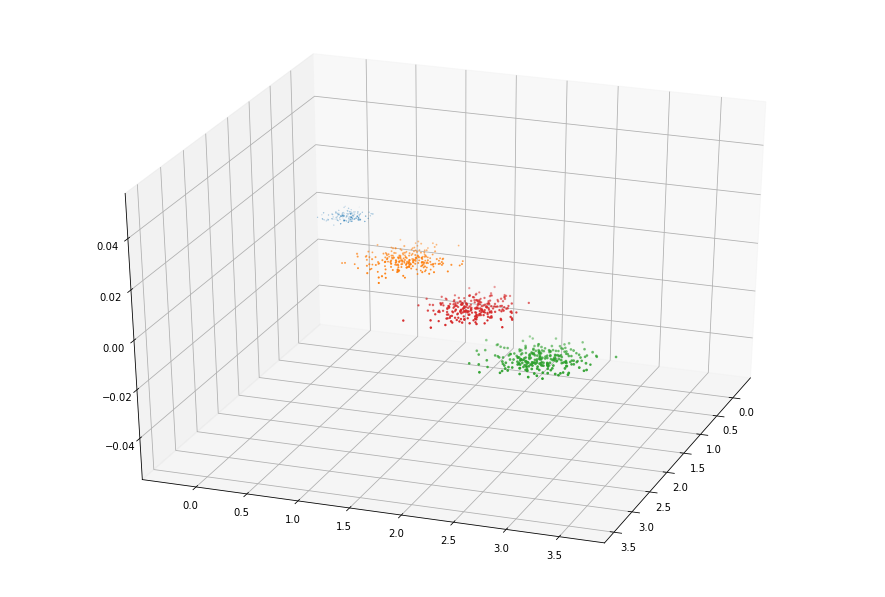

In [1]:
import math
import random
from sklearn import datasets
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline



# 正规化数据集 X
def normalize(X, axis=-1, p=2):
    lp_norm = np.atleast_1d(np.linalg.norm(X, p, axis))
    lp_norm[lp_norm == 0] = 1
    return X / np.expand_dims(lp_norm, axis)


# 计算一个样本与数据集中所有样本的欧氏距离的平方
def euclidean_distance(one_sample, X):
    one_sample = one_sample.reshape(1, -1)
    X = X.reshape(X.shape[0], -1)
    distances = np.power(np.tile(one_sample, (X.shape[0], 1)) - X, 2).sum(axis=1)
    return distances





class KMedoids():
    """
    k-medoids聚类算法.


    Parameters:
    -----------
    k: int
        聚类簇的数目.
    max_iterations: int
        最大迭代次数. 
    varepsilon: float
        判断是否收敛, 如果上一次的所有k个聚类中心与本次的所有k个聚类中心的差都小于varepsilon, 
        则说明算法已经收敛
    """
    def __init__(self, k=2, max_iterations=500, varepsilon=0.0001):
        self.k = k
        self.max_iterations = max_iterations
        self.varepsilon = varepsilon

    # 随机初始化k个聚类中心
    def init_random_medoids(self, X):
        n_samples, n_features = np.shape(X)
        medoids = np.zeros((self.k, n_features))
        for i in range(self.k):
            medoid = X[np.random.choice(range(n_samples))]
            medoids[i] = medoid
        return medoids

    # 返回离该样本最近的中心的索引
    def closest_medoid(self, sample, medoids):
        distances = euclidean_distance(sample, medoids)
        closest_i = np.argmin(distances)
        return closest_i

    # 将每一个样本分配到与其最近的一个中心
    def create_clusters(self, X, medoids):
        clusters = [[] for _ in range(self.k)]
        for sample_i, sample in enumerate(X):
            medoid_i = self.closest_medoid(sample, medoids)
            clusters[medoid_i].append(sample_i)
        return clusters

    # 计算cost (所有样本到其相应中心的距离之和)
    def calculate_cost(self, X, clusters, medoids):
        cost = 0
        # For each cluster
        for i, cluster in enumerate(clusters):
            medoid = medoids[i]
            cost += euclidean_distance(medoid, X[cluster]).sum()
        return cost

    # Returns a list of all samples that are not currently medoids
    def get_X_no_medoids(self, X, medoids):
        no_medoids = []
        for sample in X:
            if not sample in medoids:
                no_medoids.append(sample)
        return no_medoids

    # 获取每个样本的label, 方法是将每个簇的索引号记做该簇中样本的label
    def get_cluster_labels(self, clusters, X):
        y_pred = np.zeros(np.shape(X)[0])
        for i, cluster in enumerate(clusters):
            y_pred[cluster] = i
        return y_pred

    # Do Partitioning Around Medoids and return the cluster labels
    def predict(self, X):
        # 随机初始化self.k个中心
        medoids = self.init_random_medoids(X)
        # 进行cluster，将整个数据集中样本分配到与其最近的中心
        clusters = self.create_clusters(X, medoids)

        # 计算初始损失 (所有样本到其相应中心的距离之和)
        cost = self.calculate_cost(X, clusters, medoids)

        # 迭代, 直到 cost 不再下降
        for i in range(self.max_iterations):
            best_medoids = medoids
            lowest_cost = cost
            # 遍历所有中心(或者簇(clusters))
            for medoid in medoids:
                # 获取所有非中心的样本
                X_no_medoids = self.get_X_no_medoids(X, medoids)
                # 遍历所有非中心的样本
                for sample in X_no_medoids:
                    # Swap sample with the medoid
                    new_medoids = medoids.copy()
                    new_medoids[medoids == medoid] = sample
                    # 按照新的中心划分簇(clusters)
                    new_clusters = self.create_clusters(X, new_medoids)
                    # 计算中心更新之后的 cost
                    new_cost = self.calculate_cost(X, new_clusters, new_medoids)
                    # 如果中心更新之后的cost < 更新之前的cost, 则将中心, cost进行更新
                    if new_cost < lowest_cost:
                        lowest_cost = new_cost
                        best_medoids = new_medoids
            # If there was a swap that resultet in a lower cost we save the
            # resulting medoids from the best swap and the new cost 
            if lowest_cost < cost:
                cost = lowest_cost
                medoids = best_medoids
            # Else finished
            else:
                break
                
        # 按照最终(最优)的中心再划分簇(clusters)
        final_clusters = self.create_clusters(X, medoids)
        # 按照最终(最优)的簇(clusters)获取所有样本的label
        return self.get_cluster_labels(final_clusters, X)


def main():
    # Load the dataset
    X, y = datasets.make_blobs(n_samples=1000, 
                               n_features=3, 
                               centers=[[3,3, 3], [0,0,0], [1,1,1], [2,2,2]], 
                               cluster_std=[0.2, 0.1, 0.2, 0.2], 
                               random_state =9)
    
    # 用Kmeans算法进行聚类
    clf = KMedoids(k=4)
    y_pred = clf.predict(X)
    
    # 可视化聚类效果
    fig = plt.figure(figsize=(12, 8))
    ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=30, azim=20)
    plt.scatter(X[y_pred==0][:, 0], X[y_pred==0][:, 1], X[y_pred==0][:, 2])
    plt.scatter(X[y_pred==1][:, 0], X[y_pred==1][:, 1], X[y_pred==1][:, 2])
    plt.scatter(X[y_pred==2][:, 0], X[y_pred==2][:, 1], X[y_pred==2][:, 2])
    plt.scatter(X[y_pred==3][:, 0], X[y_pred==3][:, 1], X[y_pred==3][:, 2])
    plt.show()
    

if __name__ == "__main__":
    main()